Randome Forest

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Read Data

In [2]:
import numpy as np
import pandas as pd
import math
import re

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


df_train = pd.read_csv('data/train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df_train_label = df_train[["Id", "SalePrice"]]
df_train = df_train.drop('SalePrice', axis=1)

df_train = df_train.set_index("Id")
df_train_label = df_train_label.set_index("Id")

df_test = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

test_null_columns=df_test.columns[df_test.isnull().any()] 
train_null_columns=df_train.columns[df_train.isnull().any()] 
test_null_only_ColIdx = test_null_columns.difference(train_null_columns)

test_null_only_RowIdx = [ df_test[df_test[idx].isnull()].index.tolist() for idx in test_null_only_ColIdx ]
test_null_only_RowIdx = list ( set(x for l in test_null_only_RowIdx for x in l) )

problematicTestSet = df_test.loc[ df_test.index.isin( test_null_only_RowIdx ) ]

fineTestSet = df_test.loc[ ~df_test.index.isin( test_null_only_RowIdx ) ]  #1447 records

problematicTestSet= problematicTestSet.set_index("Id")
fineTestSet = fineTestSet.set_index("Id")
df_test = df_test.set_index("Id")

df = pd.concat([df_train,df_test], axis=0, sort=True)

problematicTestSet.index

Int64Index([1556, 1916, 1946, 2121, 2152, 2189, 2217, 2251, 2474, 2490, 2577, 2905], dtype='int64', name='Id')

Impute Data with preprocess.py subfunction

In [3]:
from preprocess import impute
df_label_count, encodedDic = impute( df_train, False) 

In [5]:
df_test = df_label_count[df_label_count.index >= min(df_test.index)]
df_train = df_label_count[df_label_count.index < min(df_test.index)]
#df_train_label

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1122b4710>]],
      dtype=object)

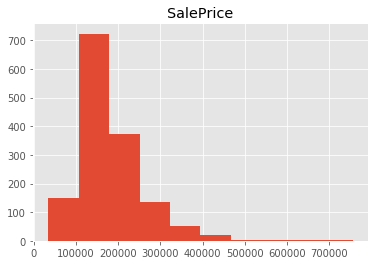

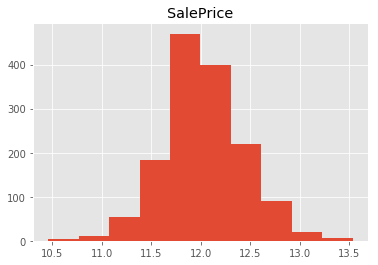

In [6]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )
df_train_label.hist()
df_train_label_log.hist()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

cvrmse = np.sqrt(-cross_val_score( RandomForestRegressor(), df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )

cvrmse

array([0.14724074, 0.1249532 , 0.14280861, 0.15543195, 0.16639435,
       0.12415025, 0.14181213, 0.12230998, 0.15318683, 0.16298671])

In [9]:
def evaluate(model, test_features, test_labels): 
    
    predictions = model.predict(test_features).ravel()  
    residuals = test_labels - predictions
    rmse = np.sqrt( mean_squared_error(test_labels, predictions ))
    rmsle = np.sqrt(np.mean((np.log1p(predictions) - np.log1p(test_labels))**2))    
    pred = pd.DataFrame( {'residuals': residuals.values, 'predictions': predictions} )
    pred.set_index(residuals.index)
    
    return [rmse, rmsle, pred]

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [11]:
# Create the random grid
random_grid_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid_param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [12]:
# n_iter, which controls the number of different combinations to try
# More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time.
rf = RandomForestRegressor()

random_grid = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid_param, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               scoring='neg_mean_squared_error',
                               n_jobs = -1)

# Fit the random search model
random_grid.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.8s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   6.6s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   6.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=  13.4s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=  13.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  50.5s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimator

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=  13.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   7.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=  11.5s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=  11.2s
[CV] n_estimators=1

[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   4.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   4.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   5.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  10.3s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800,

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   7.5s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   7.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   7.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   7.8s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.0min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  28.8s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  27.7s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total= 1.0min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  27.9s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=  27.9s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   9.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   9.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   9.4s
[CV] n_estimator

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=  14.9s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.6s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   4.2s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   4.4s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.6s
[CV] n_estimators=1600, mi

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   5.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   5.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=  35.0s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=  12.1s
[CV] n_estimators=2000,

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 23.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [13]:
print(random_grid.best_params_)
model_rf_best = random_grid.best_estimator_

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


RMSE = 0.1310
RMSLE = 0.0100


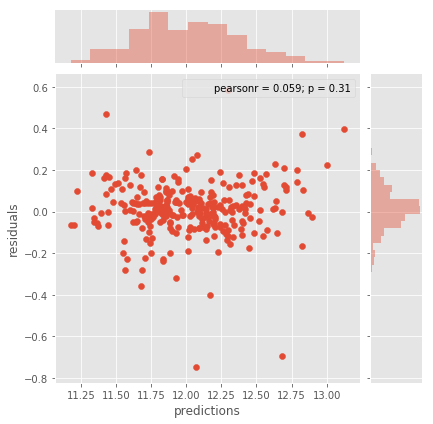

In [14]:
rmse, rmsle, pred = evaluate(model_rf_best, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

In [15]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_d

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.0s
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, m

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.7s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, m

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, mi

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_f

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_f

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.5s
[CV] bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fe

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.7min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_f

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [16]:
print( grid_search.best_params_ )
best_grid = grid_search.best_estimator_

{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}


RMSE = 0.1553
RMSLE = 0.0118


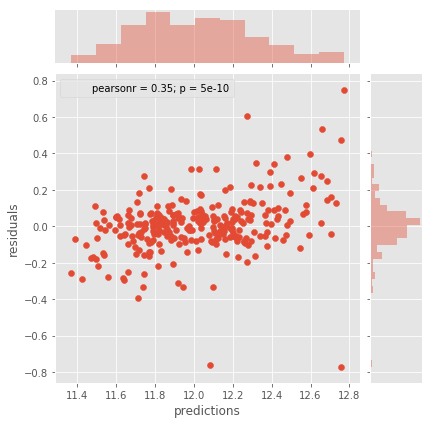

In [17]:
rmse, rmsle, pred = evaluate(best_grid, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

RMSE = 0.1515
RMSLE = 0.0116


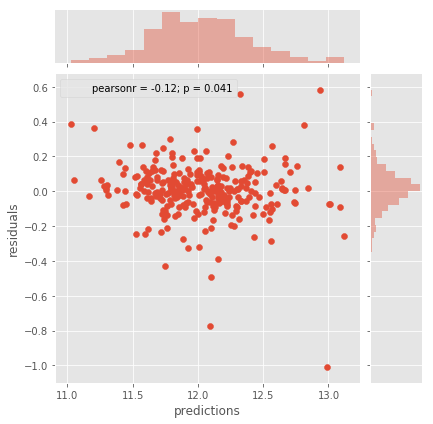

In [18]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

rmse, rmsle, pred = evaluate(model_rf, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

RMSE: 0.151532
KstestResult(statistic=0.3668260406789454, pvalue=0.0)


<Figure size 432x288 with 0 Axes>

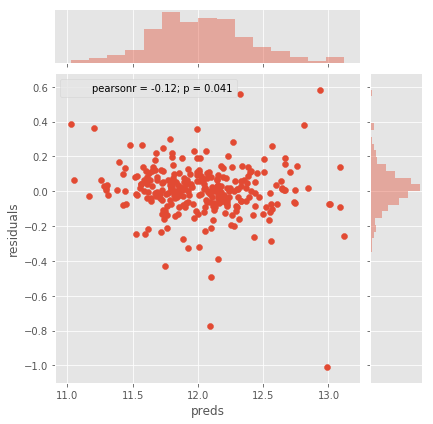

In [19]:
plt.figure()
plt.rcParams['figure.figsize'] = (6.0, 6.0)

#preds = df_train_label_log.copy()
#preds["preds"] = model_rf.predict(df_train)
preds = y_test.copy()
preds["preds"] = model_rf.predict(X_test)

preds["residuals"] = preds["SalePrice"] - preds["preds"]
sns.jointplot(x = "preds", y = "residuals",  data=preds )

#rmse = np.sqrt( mean_squared_error(df_train_label_log, preds["preds"]))
rmse = np.sqrt( mean_squared_error(y_test, preds["preds"]))
print("RMSE: %f" % (rmse))

from scipy.stats import kstest
test_stat = kstest( preds["residuals"] , 'norm')  #the residuals is not normally distributed.
print(test_stat)

Text(0.5,0,'Relative Importance')

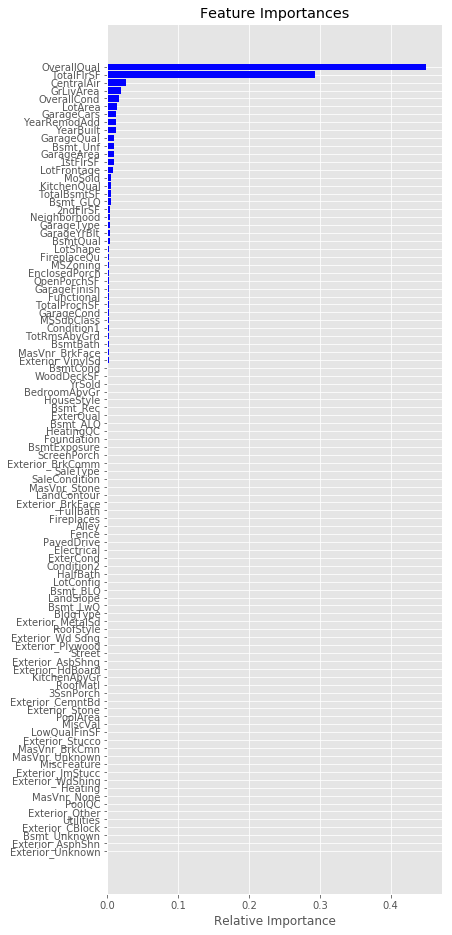

In [20]:
plt.rcParams['figure.figsize'] = (6.0, 16.0)
features= df_train.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [28]:
import pickle
with open('rf.pkl', 'wb') as handle:
    pickle.dump(model_rf, handle, protocol=pickle.HIGHEST_PROTOCOL)